In [1]:
import torch
import requests
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
data = pd.read_csv("/content/gdrive/MyDrive/iris.data", names=['a','b','c','d','e'])
data_x = data.iloc[:,0:4] #전체 행, 0~3열 가져오기
data_y = data.iloc[:,4] #전체 행, 4열 가져오기

In [36]:
X = torch.tensor(torch.from_numpy(data_x.values), dtype=torch.float) #data_x에 있는 값 torch로 변환

<ipython-input-36-2f10402870fb>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(torch.from_numpy(data_x.values), dtype=torch.float) #data_x에 있는 값 torch로 변환


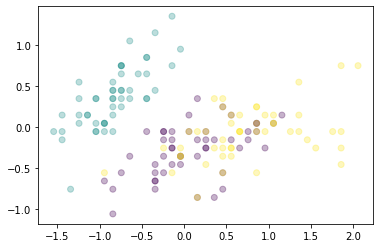

In [37]:
Z = X - X.mean(dim=0) #각 열(축)의 평균 구하고,빼줌 => 축을 0으로 옮겨줌 
species = {x:i for i,x in enumerate(set(data_y))} # =>{'Iris-setosa': 0, 'Iris-virginica': 1, 'Iris-versicolor': 2}
sp = [species[d] for d in data_y]
#sp = 2,2,2,0,0,0,1,1,....,0

plt.scatter(Z[:,0], Z[:,1], c=sp, alpha=0.3) 
plt.show ()

In [38]:
#분산을 최대로 하는 w벡터 찾기
def findPC(Z):
  #내적해서 분산 구하기
  #random vector w
  w = torch.randn(Z.shape[1])
  #Z.shape[1] = 4
  w /= (w**2).sum()**0.5
  lr = 0.1

  for epoch in range(101):
    w.requires_grad_(True)
    #w에 사영했을 때의 분산 구하기
    variance = ((Z*w).sum(dim=1)**2).mean()
    #분산의 기울기 구하기
    variance.backward()
    
    with torch.no_grad():
      #w 업데이트
      w = w + lr*w.grad #기울기(분산)가 커지는 방향대로 이동시키기 때문에 +
      w /= (w**2).sum()**0.5 
  w.requires_grad_(False)

  return w, variance.item()

In [33]:
# res = findPC(Z)
# res

(tensor([ 0.3616, -0.0823,  0.8566,  0.3588]), 4.196675777435303)

In [39]:
#순서대로 주성분 찾기
def PCA(k,Z):
  PC = []
  VAR = []
  Z = torch.tensor(Z) # Z 복사

  for i in range(k):
    w, v = findPC(Z)
    PC.append(w)
    VAR.append(v)

    Z -= w * (Z*w).sum(dim=1).unsqueeze(1)

  return PC, VAR

res = PCA(4,Z)
res

<ipython-input-39-3b5ef9cd7f88>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z = torch.tensor(Z) # Z 복사


([tensor([ 0.3616, -0.0823,  0.8566,  0.3588]),
  tensor([ 0.4883,  0.8533, -0.1573,  0.0932]),
  tensor([ 0.6205, -0.4373,  0.0785, -0.6462]),
  tensor([ 0.5478,  0.0722,  0.2482, -0.7957])],
 [4.196674823760986,
  0.22838269174098969,
  0.08478593081235886,
  0.0041851201094686985])

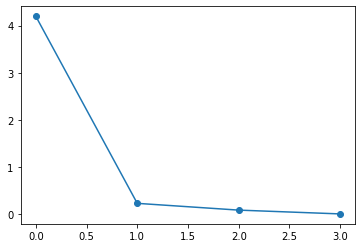

In [40]:
plt.plot(res[1], "-o")
plt.show()

In [42]:
#각 축이 주성분이 되도록 기존 데이터를 변경
def transform(Z,W):
  return Z @ torch.stack(W).T

W,_ = PCA(2,Z)
A = transform(Z,W)

<ipython-input-39-3b5ef9cd7f88>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z = torch.tensor(Z) # Z 복사


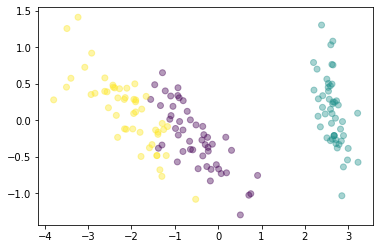

In [43]:
plt.scatter(A[:,0], A[:,1], c=sp, alpha=0.4)